Ahora mismo:
- Implementación de CAM
- Cats vs Dogs con red sencilla para probar CAM
- Tratamiento de Camelyon17
- Índice de la memoria + parte teórica

Pasos siguientes:
- Implementación de GradCAM, GradCAM++, y SmoothGradCAM++
- Selección de clasificadores (torch.models) (VGG, ResNet, Inception, MobileNet)
- Entrenamiento de los clasificadores en Camelyon17-tratado
- Explicación con CAM, GradCAM, GradCAM++ y SmoothGradCAM++ con los modelos entrenados
- Análisis de resultados


In [ ]:
# -*- coding: utf-8 -*-

# En primer lugar cargamos nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 

Mounted at /content/drive


In [ ]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import numpy as np

import os

import time
import os
import copy
import math

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
model_vgg = models.vgg16(pretrained=True)
print(model_vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# pool of non-square window
m = nn.AdaptiveAvgPool2d(output_size=(7,7))
lin = nn.Linear(in_features=512, out_features = 4096, bias = True)
mm = nn.AvgPool2d(20)
l=[]
for i in range(20):
  row=[]
  for j in range(20):
    row.append(float(20*i+j))
  l.append(row)


arr=np.array([l])
input = torch.from_numpy(arr)
input = torch.rand(512,30,30)
"""
# Ejecutamos los pooling
output = m(input)
print(f"tensor:\n {output}\n\nOutput shape: {output.shape}")
output2 = lin(torch.reshape(output, (1,25088)))
print(f"tensor:\n {output2}\n\nOutput shape: {output2.shape}")
"""
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x7 and 25088x4096)

output = mm(input)
#print(f"tensor:\n {output}\n\nOutput shape: {output.shape}")

In [ ]:
class VGG16_CAM(nn.Module):
  def __init__(self, originalModel, D_out):
    super(VGG16_CAM, self).__init__()
    self.features = nn.Sequential(*list(originalModel.features)) 
    self.avgPool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc = nn.Linear(in_features=512, out_features=D_out, bias=False)


  def forward(self, x):
    x=self.features(x)
    x=self.avgPool(x)
    sh=x.shape
    x=torch.reshape(x,(sh[0],sh[1]))
    x=self.fc(x)
    return x


class VGG16_GradCAM(nn.Module):
  def __init__(self, originalModel, D_out):
    super(VGG16_GradCAM, self).__init__()
    self.features = nn.Sequential(*list(originalModel.features)) 
    self.avgPool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
    self.classifier = nn.Sequential(*list(originalModel.classifier))
    self.fc = nn.Linear(in_features=originalModel.classifier[-1].out_features, out_features=D_out, bias=False)


  def forward(self, x):
    x=self.features(x)
    x=self.avgPool(x)
    
    sh=x.shape
    second_dim = 1
    for s in sh[1:]:
      second_dim = second_dim*s

    x=torch.reshape(x,(sh[0],second_dim))
    x=self.classifier(x)
    x=self.fc(x)
    return x

  


In [ ]:
m = nn.Softmax(dim=-1)
mm = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output1 = m(input)
print(input)
print()
print(output1)
print(np.sum(output1.numpy(), axis=0))

output2 = mm(input)
print()
print(output2)
print(np.sum(output2.numpy(), axis=0))



tensor([[0.0251, 0.4768, 0.0134],
        [0.8925, 1.7418, 0.0153]])

tensor([[0.2809, 0.4414, 0.2777],
        [0.2664, 0.6228, 0.1108]])
[0.5473281 1.0641925 0.3884793]

tensor([[0.2809, 0.4414, 0.2777],
        [0.2664, 0.6228, 0.1108]])
[0.5473281 1.0641925 0.3884793]


# PREPARAMOS LOS DIRECTORIOS DE LOS DATOS
Puesto que carecemos de archivo de etiquetas y las etiquetas vienen en el nombre, es necesario organizar los archivos en carpetas de /dogs y /cats para poder almacenar las etiquetas en pytorch (tendrá un valor u otro según de donde leamos y posteriormente se hará un shuffle)

In [ ]:
# Ver la página
# https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

In [ ]:
path = "drive/MyDrive/Cats_vs_Dogs"
"""
!ls {path}
!ls {path}/test/cats | wc -l
!ls {path}/test/dogs | wc -l
!ls {path}/train/cats | wc -l
!ls {path}/train/dogs | wc -l
!ls {path}/val/cats | wc -l
!ls {path}/val/dogs | wc -l
"""

'\n!ls {path}\n!ls {path}/test/cats | wc -l\n!ls {path}/test/dogs | wc -l\n!ls {path}/train/cats | wc -l\n!ls {path}/train/dogs | wc -l\n!ls {path}/val/cats | wc -l\n!ls {path}/val/dogs | wc -l\n'

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
    ])
}

data_dir = 'drive/MyDrive/Cats_vs_Dogs'
CHECK_POINT_PATH = 'drive/MyDrive/Cats_vs_Dogs/checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, 
                                              shuffle=True, num_workers=1)


class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')
print(f'Test image size: {len(dataset_test)}')

['cats', 'dogs']
Train image size: 18000
Validation image size: 2000
Test image size: 5000


In [ ]:
"""
def imshow(inp, title=None):
    #Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)
"""
inputs, classes = next(iter(dataloaders['train']))
print(inputs[0].shape)

torch.Size([3, 224, 224])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
  since = time.time()
  if checkpoint is None:
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.
  else:
    print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
    
        # Iterate over data.
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          
          if i % 200 == 199:
              print('[%d, %d] loss: %.3f' % 
                    (epoch + 1, i, running_loss / (i * inputs.size(0))))

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              
              # backward + optimize only if in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()
          
          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            print(f'New best model found!')
            print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
            best_loss = epoch_loss
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)
    
  return model, best_loss, best_acc



model_conv = VGG16_CAM(model_vgg, D_out=2)
model_conv_grad = VGG16_GradCAM(model_vgg, D_out=2)
#model_conv = model_vgg


model_conv = model_conv.to(device)
model_conv_grad = model_conv_grad.to(device)
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

"""
#model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
#torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

model_conv_grad, best_val_loss, best_val_acc = train_model(model_conv_grad,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)

torch.save(model_conv_grad, "drive/MyDrive/Cats_vs_Dogs/model_conv_grad.pth")
"""

checkpoint loaded


'\n#model_conv, best_val_loss, best_val_acc = train_model(model_conv,\n                                                      criterion,\n                                                      optimizer_conv,\n                                                      exp_lr_scheduler,\n                                                      num_epochs = 3,\n                                                      checkpoint = checkpoint)\n#torch.save({\'model_state_dict\': model_conv.state_dict(),\n            \'optimizer_state_dict\': optimizer_conv.state_dict(),\n            \'best_val_loss\': best_val_loss,\n            \'best_val_accuracy\': best_val_acc,\n            \'scheduler_state_dict\' : exp_lr_scheduler.state_dict(),\n            }, CHECK_POINT_PATH)\n\nmodel_conv_grad, best_val_loss, best_val_acc = train_model(model_conv_grad,\n                                                      criterion,\n                                                      optimizer_conv,\n                     

In [ ]:

model_conv = torch.load("drive/MyDrive/Cats_vs_Dogs/model.pth")
model_conv_grad = torch.load("drive/MyDrive/Cats_vs_Dogs/model_conv_grad.pth")


model_conv = model_conv.to(device)

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")


checkpoint loaded


torch.Size([7, 7])
PESOS_ALPHA: 512, max:0.008361464366316795, min:-0.010759716853499413
torch.Size([7, 7])
PESOS_ALPHA: 512, max:0.002718525007367134, min:-0.0023916084319353104
torch.Size([7, 7])
1.- min: -1.9947216510772705, max: 39.2258186340332
2.- min: -33.18470001220703, max: 2.2811882495880127
3.- min: -1.9947216510772705, max: 39.225826263427734
dist: 1.7810149074648507e-05
Pues no son igualesxd


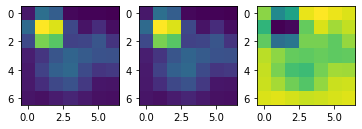

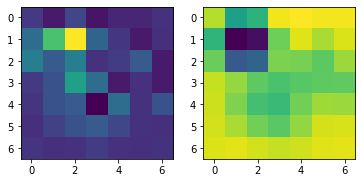

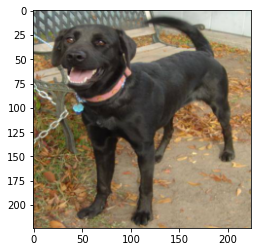

CAM:1
Grad-CAM:1
----------- ES UN PERRO -----------


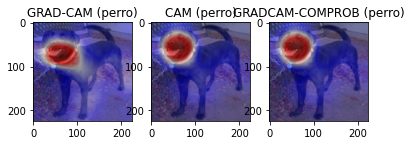

c=tensor([1], device='cuda:0')
PREDICCIÓN CAM: tensor([[4.3876e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
PREDICCIÓN GRADCAM: tensor([[0.0023, 0.9977]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [ ]:
# Cogemos la activación de las capas
x, classes=next(iter(dataloader_test))
x=x.to(device)
classes=classes.to(device)

soft = nn.Softmax(dim=1)

# CAM
model_conv.eval()
y_pred_cam = torch.argmax(soft(model_conv(x)),axis=1)

activacion = model_conv.features(x)
act_shape = activacion.shape
activacion = torch.reshape(activacion, (act_shape[1],act_shape[2],act_shape[3]))

heatmap_gato = torch.zeros((activacion.shape[1],activacion.shape[2])).to(device)
heatmap_perro = torch.zeros((activacion.shape[1],activacion.shape[2])).to(device)

for p in model_conv.fc.parameters():
  for i in range(activacion.shape[0]):
    heatmap_gato = heatmap_gato + activacion[i]*p[0][i]
    heatmap_perro = heatmap_perro + activacion[i]*p[1][i]

# Normalizamos
"""
maximo_ambos = max(torch.max(heatmap_gato), torch.max(heatmap_perro))
minimo_ambos = min(torch.min(heatmap_gato), torch.min(heatmap_perro))
print(f"MAXIMO: {maximo_ambos}")
print(f"MINIMO: {minimo_ambos}")

heatmap_gato = (heatmap_gato-minimo_ambos)/(abs(maximo_ambos-minimo_ambos))
heatmap_perro = (heatmap_perro-minimo_ambos)/(abs(maximo_ambos-minimo_ambos))
"""
print(heatmap_perro.size())

###############################################################################
# Grad-CAM
model_conv_grad.to(device)
model_conv_grad.eval()

y_pred_grad= torch.argmax(soft(model_conv_grad(x)),axis=1)


grad_activation = model_conv_grad.avgPool(model_conv_grad.features(x)) # tiene le requires_grad=True
grad_act_shape = grad_activation.shape
grad_activation =  torch.reshape(grad_activation, (1, grad_act_shape[1]*grad_act_shape[2]*grad_act_shape[3]))


grad_activation.retain_grad() # Enables this Tensor to have their grad populated during backward().
Y_grad = model_conv_grad.fc(model_conv_grad.classifier(grad_activation))
#torch.autograd.backward([Y_grad[0][0], Y_grad[0][1]])

Y_grad = torch.autograd.backward(Y_grad[0][y_pred_grad[0]])
pesos_alpha = []
for n in range(grad_act_shape[1]):
  peso_aux = 0
  for i in range(grad_act_shape[2]):
    for j in range(grad_act_shape[3]):
      peso_aux = peso_aux + grad_activation.grad[0][n*grad_act_shape[2]*grad_act_shape[3]+i*grad_act_shape[3]+j]

  pesos_alpha.append(peso_aux/float(grad_act_shape[2]*grad_act_shape[3]))


print(f"PESOS_ALPHA: {len(pesos_alpha)}, max:{max(pesos_alpha)}, min:{min(pesos_alpha)}")
pesos_alpha_tensor = torch.tensor(pesos_alpha).to(device)

activacion_final_grad = torch.zeros((grad_act_shape[2], grad_act_shape[3])).to(device)
for n in range(len(pesos_alpha)):
  ini = n*grad_act_shape[2]*grad_act_shape[3]
  fin = (n+1)*grad_act_shape[2]*grad_act_shape[3]
  aux = torch.reshape(grad_activation[0][ini:fin], (grad_act_shape[2],grad_act_shape[3]))
  activacion_final_grad = activacion_final_grad + pesos_alpha_tensor[n]*aux

relu = nn.ReLU()
heatmap_grad=relu(activacion_final_grad)
print(heatmap_grad.shape)

###############################################################################
# Comprobación gradcam
model_conv.to(device)
model_conv.eval()

y_pred_grad_comprobacion = torch.argmax(soft(model_conv(x)),axis=1)


grad_activation_comprobacion = model_conv.features(x) # tiene le requires_grad=True
grad_act_shape_comprobacion = grad_activation_comprobacion.shape


grad_activation_comprobacion.retain_grad() # Enables this Tensor to have their grad populated during backward().
aux = model_conv.avgPool(grad_activation_comprobacion)
aux_shape_comprobacion = aux.shape
aux =  torch.reshape(aux, (1, aux_shape_comprobacion[1]*aux_shape_comprobacion[2]*aux_shape_comprobacion[3]))

Y_grad_comprobacion = model_conv.fc(aux)
#torch.autograd.backward([Y_grad[0][0], Y_grad[0][1]])

Y_grad_comprobacion = torch.autograd.backward(Y_grad_comprobacion[0][y_pred_grad_comprobacion[0]])

pesos_alpha_comprobacion = []
for n in range(grad_act_shape_comprobacion[1]):
  peso_aux = 0
  for i in range(grad_act_shape_comprobacion[2]):
    for j in range(grad_act_shape_comprobacion[3]):
      peso_aux = peso_aux + grad_activation_comprobacion.grad[0][n][i][j]

  pesos_alpha_comprobacion.append(peso_aux/float(grad_act_shape_comprobacion[2]*grad_act_shape_comprobacion[3]))


print(f"PESOS_ALPHA: {len(pesos_alpha_comprobacion)}, max:{max(pesos_alpha_comprobacion)}, min:{min(pesos_alpha_comprobacion)}")
pesos_alpha_tensor_comprobacion = torch.tensor(pesos_alpha_comprobacion).to(device)

activacion_final_grad_comprobacion = torch.zeros((grad_act_shape_comprobacion[2], grad_act_shape_comprobacion[3])).to(device)
for n in range(len(pesos_alpha_comprobacion)):
 activacion_final_grad_comprobacion = activacion_final_grad_comprobacion + grad_activation_comprobacion[0][n]*pesos_alpha_comprobacion[n]

relu = nn.ReLU()
heatmap_grad_comprobacion=(activacion_final_grad_comprobacion)
print(heatmap_grad_comprobacion.shape)

###########################
#
#   HACEMOS PLOT
#
##########################
# CAM
x_plot=torch.reshape(x.cpu(), (3,224,224)).permute(1,2,0).numpy()
hm_g = heatmap_gato.cpu().detach().numpy()
hm_d = heatmap_perro.cpu().detach().numpy()
hm_grad = heatmap_grad.cpu().detach().numpy()
hm_grad_comprobacion = heatmap_grad_comprobacion.cpu().detach().numpy()

aux1=hm_grad_comprobacion*49
aux2=hm_g
aux3=hm_d
"""
aux1=(hm_grad_comprobacion-np.amin(hm_grad_comprobacion))
aux1 = aux1/np.amax(aux1)

aux2=(hm_d-np.amin(hm_d))
aux2= aux2/np.amax(aux2)

aux3=(hm_g-np.amin(hm_g))
aux3=aux3/np.amax(aux3)
"""
print(f'1.- min: {np.amin(aux1)}, max: {np.amax(aux1)}')
print(f'2.- min: {np.amin(aux2)}, max: {np.amax(aux2)}')
print(f'3.- min: {np.amin(aux3)}, max: {np.amax(aux3)}')
min_dist = min([np.linalg.norm(aux1-aux2), np.linalg.norm(aux1-aux3)])
print(f'dist: {min_dist}')


if (aux1==aux2).all() or (aux1==aux3).all():
  print("SON IGUALES!!!!")
else:
  print("Pues no son igualesxd")


fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(aux3) #gato
axes[1].imshow(aux1) #gradcam
axes[2].imshow(aux2) #perro

plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(aux3-aux1) #gato
axes[1].imshow(aux2-aux1) #perro

plt.show()

resg = cv2.resize(hm_g*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resd = cv2.resize(hm_d*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resgrad = cv2.resize(hm_grad*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resgrad_comprobacion = cv2.resize(hm_grad_comprobacion*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


plt.imshow(x_plot)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3)


print(f"CAM:{y_pred_cam[0]}")
cam_pred_name = "gato" if y_pred_cam[0]==0 else "perro"
print(f"Grad-CAM:{y_pred_grad[0]}")
gradcam_pred_name = "gato" if y_pred_grad[0]==0 else "perro"
gradcam_pred_name_comprobacion = "gato" if y_pred_grad_comprobacion[0]==0 else "perro"

if classes[0]==0:
  print("----------- ES UN GATO -----------")
    
  axes[0].imshow(x_plot)
  axes[0].imshow(resgrad,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[0].title.set_text(f"GRAD-CAM ({gradcam_pred_name})")

  axes[1].imshow(x_plot)
  axes[1].imshow(resg,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[1].title.set_text(f"CAM ({cam_pred_name})")
  
  axes[2].imshow(x_plot)
  axes[2].imshow(resgrad_comprobacion,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[2].title.set_text(f"CAM-COMPROB ({gradcam_pred_name_comprobacion})")
  plt.show()

else:
  print("----------- ES UN PERRO -----------")

  axes[0].imshow(x_plot)
  axes[0].imshow(resgrad,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[0].title.set_text(f"GRAD-CAM ({gradcam_pred_name})")

  axes[1].imshow(x_plot)
  axes[1].imshow(resd,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[1].title.set_text(f"CAM ({cam_pred_name})")
  
  axes[2].imshow(x_plot)
  axes[2].imshow(resgrad_comprobacion,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[2].title.set_text(f"GRADCAM-COMPROB ({gradcam_pred_name_comprobacion})")
  plt.show()


print(f"c={classes}")
print(f"PREDICCIÓN CAM: {soft(model_conv(x))}")
print(f"PREDICCIÓN GRADCAM: {soft(model_conv_grad(x))}")



In [ ]:
t1=torch.tensor(1., requires_grad=True)
t2=torch.tensor(2., requires_grad=True)
t3=torch.tensor(3., requires_grad=True)
################################################

t4 = t1+t2
t5=t4*t3

t5.backward()
print(t3.grad)
################################################

t1.grad=torch.zeros_like(t1)
t2.grad=torch.zeros_like(t2)
t3.grad=torch.zeros_like(t3)

t6= (t3+t1)
t7= t6*t2

t7.backward()
print(t3.grad)

##############################################
p1 = torch.tensor([[1.,-2.]], requires_grad=True)
p2 = torch.tensor([[3.,-3.]], requires_grad=True)
p3 = torch.tensor([[15.,6.]], requires_grad=True)
p4 = torch.tensor([[-2.,-3.]], requires_grad=True)

p21 = torch.mm(p2,p1)
p34 = torch.mm(p3,p4)


tensor(3.)
tensor(2.)


RuntimeError: ignored